# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance (accuracy, precision, recall, and f-score) as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client for a any sepcific number of clients of your choice. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random
from sklearn.metrics import classification_report


np.random.seed(2315119)
random.seed(2315119)
tf.random.set_seed(2315119)
K.clear_session()


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model

# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)

# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)


# Get predictions
y_pred = global_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F-score
report = classification_report(y_test, y_pred)

print(report)


313/313 - 1s - loss: 0.3375 - accuracy: 0.9118 - 732ms/epoch - 2ms/step
Test accuracy: 0.9118000268936157
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       980
           1       0.96      0.97      0.97      1135
           2       0.85      0.90      0.87      1032
           3       0.91      0.95      0.93      1010
           4       0.91      0.95      0.93       982
           5       0.93      0.91      0.92       892
           6       0.99      0.77      0.87       958
           7       0.96      0.88      0.92      1028
           8       0.92      0.87      0.89       974
           9       0.79      0.96      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



313/313 [==============================] - 1s 2ms/step


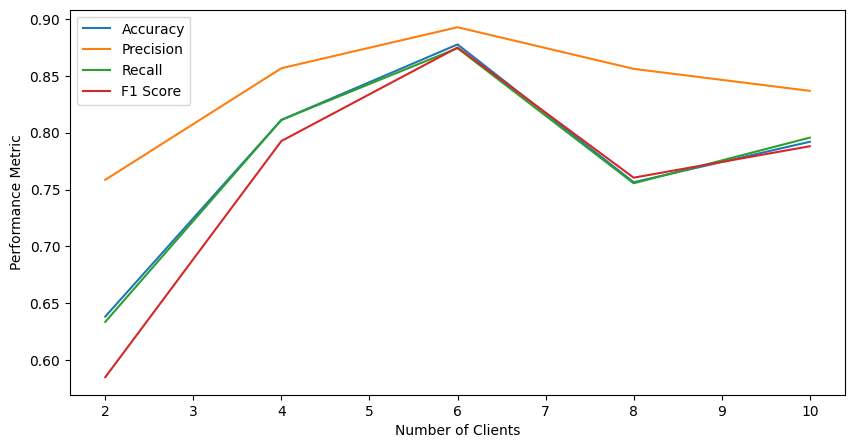

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random
from sklearn.metrics import classification_report


np.random.seed(2315119)
random.seed(2315119)
tf.random.set_seed(2315119)
K.clear_session()


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model


# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights


# List of client counts to test
client_counts = [2, 4, 6, 8, 10]

# Lists to store performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

for num_clients in client_counts:
    # Split data into clients
    x_train_clients, y_train_clients = np.array_split(x_train, num_clients), np.array_split(y_train, num_clients)

    # Create and train client models
    client_models = [create_client_model() for _ in range(num_clients)]
    for model, x, y in zip(client_models, x_train_clients, y_train_clients):
        model = train_client_model(model, x, y)

    # Federated averaging
    aggregated_weights = client_models[0].get_weights()
    for model in client_models[1:]:
        aggregated_weights = federated_average_weights(aggregated_weights, model.get_weights())

    # Create global model and set weights
    global_model = create_client_model()
    global_model.set_weights(aggregated_weights)

    # Evaluate global model
    test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(test_acc)

    # Get predictions
    y_pred = global_model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate precision, recall, and F-score
    report = classification_report(y_test, y_pred, output_dict=True)
    precisions.append(report['macro avg']['precision'])
    recalls.append(report['macro avg']['recall'])
    f1_scores.append(report['macro avg']['f1-score'])

# Plot performance metrics
plt.figure(figsize=(10, 5))
plt.plot(client_counts, accuracies, label='Accuracy')
plt.plot(client_counts, precisions, label='Precision')
plt.plot(client_counts, recalls, label='Recall')
plt.plot(client_counts, f1_scores, label='F1 Score')
plt.xlabel('Number of Clients')
plt.ylabel('Performance Metric')
plt.legend()
plt.show()

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
# Define the models
NumberOfClients = ['2', '4', '6', '8','10']

# Define the metrics
metrics = {
    'Accuracy': accuracies,  # Example values, you can change them
    'Precision': precisions,  # Example values, you can change them
    'Recall': recalls,     # Example values, you can change them
    'F1 Score': f1_scores    # Example values, you can change them
}

# Create the DataFrame
df = pd.DataFrame(metrics, index=NumberOfClients)

# Print the DataFrame
print(df)

    Accuracy  Precision    Recall  F1 Score
2     0.6383   0.758537  0.633592  0.584944
4     0.8112   0.856666  0.811267  0.792656
6     0.8776   0.892726  0.874318  0.874869
8     0.7564   0.856121  0.755514  0.760415
10    0.7920   0.836770  0.795635  0.788069


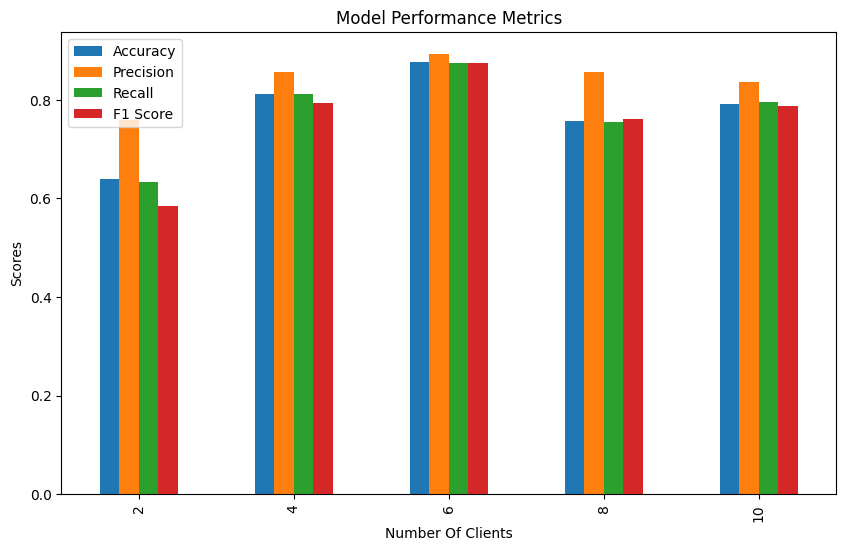

In [44]:
# Plot the DataFrame as a bar chart
df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('Number Of Clients')
plt.ylabel('Scores')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random
from sklearn.metrics import classification_report

np.random.seed(2315119)
random.seed(2315119)
tf.random.set_seed(2315119)
K.clear_session()

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Introduce a dishonest client by changing the labels of the first 1000 samples to '4'
num_dishonest_labels = 1000
y_train[:num_dishonest_labels] = 4

def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model

# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

# List of client counts to test
client_counts = [2, 4, 6, 8, 10]

# Lists to store performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

for num_clients in client_counts:
    # Split data into clients
    x_train_clients, y_train_clients = np.array_split(x_train, num_clients), np.array_split(y_train, num_clients)

    # Create and train client models
    client_models = [create_client_model() for _ in range(num_clients)]
    for model, x, y in zip(client_models, x_train_clients, y_train_clients):
        model = train_client_model(model, x, y)

    # Federated averaging
    aggregated_weights = client_models[0].get_weights()
    for model in client_models[1:]:
        aggregated_weights = federated_average_weights(aggregated_weights, model.get_weights())

    # Create global model and set weights
    global_model = create_client_model()
    global_model.set_weights(aggregated_weights)

    # Evaluate global model
    test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(test_acc)

    # Get predictions
    y_pred = global_model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate precision, recall, and F1-score
    report = classification_report(y_test, y_pred, output_dict=True)
    precisions.append(report['macro avg']['precision'])
    recalls.append(report['macro avg']['recall'])
    f1_scores.append(report['macro avg']['f1-score'])

# Plot performance metrics
plt.figure(figsize=(10, 5))
plt.plot(client_counts, accuracies, label='Accuracy')
plt.plot(client_counts, precisions, label='Precision')
plt.plot(client_counts, recalls, label='Recall')
plt.plot(client_counts, f1_scores, label='F1 Score')
plt.xlabel('Number of Clients')
plt.ylabel('Performance Metric')
plt.legend()
plt.show()

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
# Define the models
NumberOfClients = ['All Honest', '#6 Dishonest']

# Define the metrics
metrics = {
    'Accuracy': [0.8776,0.6440],  # Example values, you can change them
    'Precision': [0.892726,0.765386],  # Example values, you can change them
    'Recall': [0.874318,0.637961],     # Example values, you can change them
    'F1 Score': [0.874869,0.615177]    # Example values, you can change them
}
# Create the DataFrame
df = pd.DataFrame(metrics, index=NumberOfClients)

# Print the DataFrame
print(df)

              Accuracy  Precision    Recall  F1 Score
All Honest      0.8776   0.892726  0.874318  0.874869
#6 Dishonest    0.6440   0.765386  0.637961  0.615177


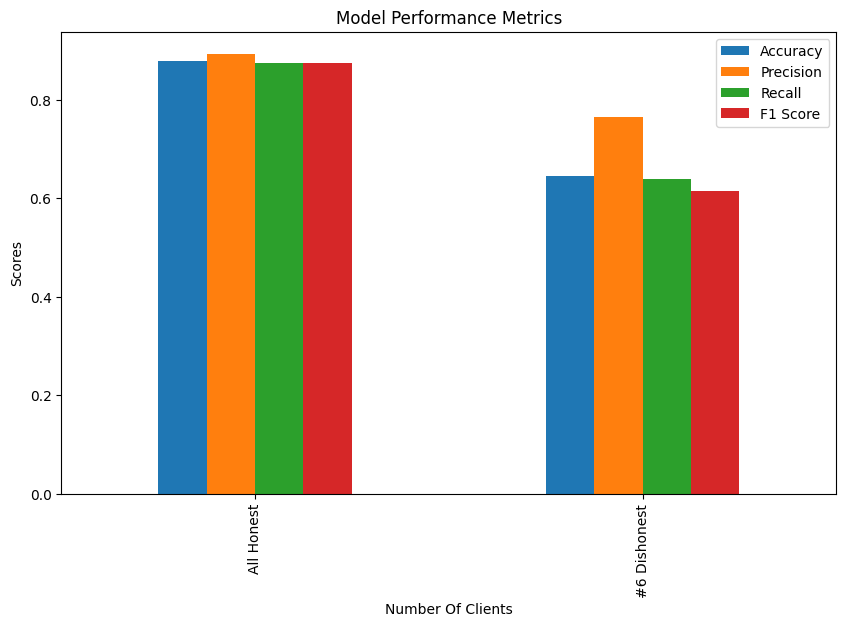

In [51]:
# Plot the DataFrame as a bar chart
df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('Number Of Clients')
plt.ylabel('Scores')

# Show the plot
plt.show()

# Lab Logbook requirement: Document the following in lablogbook

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.




# Challenges (Optional):

## The above code is for one communication round. Write code for multiple communication rounds. In each communication round, clients will train the model on a new dataset. Then the server will merge all these models. Subsequently, the clients will retrain the merged model in the next communication round.

